# Flight Delay Prediction

**Target:** `ARRIVAL_DELAY > 15 min` (Binary Classification)

## 1. Data Loading

In [1]:
import pandas as pd
import numpy as np

# S3 Configuration
BUCKET = 'sagemaker-us-east-1-425709451100'
PREFIX = 'aai540-group1/data/raw/'
BASE_URL = f"https://{BUCKET}.s3.us-east-1.amazonaws.com/{PREFIX}"

print("=" * 70)
print("LOADING DATA FROM S3")
print("=" * 70)
print(f"Bucket: {BUCKET}")
print(f"Prefix: {PREFIX}")
print()

# Load datasets
print("Loading flights.csv (this may take 30-60 seconds)...")
df_flights = pd.read_csv(BASE_URL + "flights.csv", low_memory=False)
print(f"✓ Flights loaded: {len(df_flights):,} rows × {df_flights.shape[1]} columns")

print("\nLoading airlines.csv...")
df_airlines = pd.read_csv(BASE_URL + "airlines.csv")
print(f"✓ Airlines loaded: {len(df_airlines):,} rows")

print("\nLoading airports.csv...")
df_airports = pd.read_csv(BASE_URL + "airports.csv")
print(f"✓ Airports loaded: {len(df_airports):,} rows")

print("\n" + "=" * 70)
print("DATA LOADING COMPLETE")
print("=" * 70)

# Quick peek at the data
print("\n📊 Flights Dataset Sample:")
print(df_flights.head(3))

print("\n📊 Dataset Info:")
print(f"Date range: {df_flights['YEAR'].unique()[0]}")
print(f"Months: {sorted(df_flights['MONTH'].unique())}")
print(f"Airlines: {df_flights['AIRLINE'].nunique()}")
print(f"Airports: {df_flights['ORIGIN_AIRPORT'].nunique()} origin, {df_flights['DESTINATION_AIRPORT'].nunique()} destination")

# Create lookup dictionaries for airline and airport names
airline_names = dict(zip(df_airlines['IATA_CODE'], df_airlines['AIRLINE']))
airport_names = dict(zip(df_airports['IATA_CODE'], df_airports['AIRPORT']))

print(f"Airlines: {len(airline_names)} carriers")
print(f"Airports: {len(airport_names)} locations")


LOADING DATA FROM S3
Bucket: sagemaker-us-east-1-425709451100
Prefix: aai540-group1/data/raw/

Loading flights.csv (this may take 30-60 seconds)...
✓ Flights loaded: 5,819,079 rows × 31 columns

Loading airlines.csv...
✓ Airlines loaded: 14 rows

Loading airports.csv...
✓ Airports loaded: 322 rows

DATA LOADING COMPLETE

📊 Flights Dataset Sample:
   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS             98      N407AS   
1  2015      1    1            4      AA           2336      N3KUAA   
2  2015      1    1            4      US            840      N171US   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  ...  ARRIVAL_TIME  \
0            ANC                 SEA                    5  ...         408.0   
1            LAX                 PBI                   10  ...         741.0   
2            SFO                 CLT                   20  ...         811.0   

   ARRIVAL_DELAY  DIVERTED  CANCELLED  CANCEL

## 2. Exploratory Data Analysis

### 2.1 Target Variable

TARGET VARIABLE: ARRIVAL_DELAY
Delayed (>15 min):  1,023,498 (17.6%)
On-Time (<=15 min): 4,690,510 (80.6%)
Missing:            105,071 (1.8%)

Class Imbalance: 4.58:1


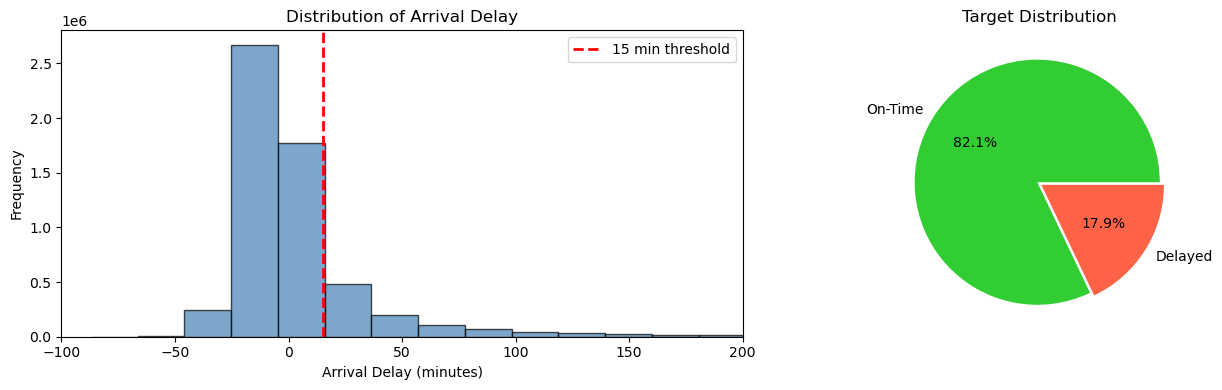

In [2]:
"""
Target Variable Analysis

Analyze the distribution of arrival delays and create the binary classification target.
Delayed flights are defined as those with ARRIVAL_DELAY > 15 minutes.
"""
import matplotlib.pyplot as plt
import seaborn as sns

delayed_count = (df_flights['ARRIVAL_DELAY'] > 15).sum()
on_time_count = (df_flights['ARRIVAL_DELAY'] <= 15).sum()
missing_count = df_flights['ARRIVAL_DELAY'].isna().sum()
total = len(df_flights)

print("TARGET VARIABLE: ARRIVAL_DELAY")
print("=" * 50)
print(f"Delayed (>15 min):  {delayed_count:,} ({delayed_count / total * 100:.1f}%)")
print(f"On-Time (<=15 min): {on_time_count:,} ({on_time_count / total * 100:.1f}%)")
print(f"Missing:            {missing_count:,} ({missing_count / total * 100:.1f}%)")
print(f"\nClass Imbalance: {on_time_count / delayed_count:.2f}:1")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram of arrival delay distribution
axes[0].hist(
    df_flights['ARRIVAL_DELAY'].dropna(),
    bins=100,
    color='steelblue',
    edgecolor='black',
    alpha=0.7
)
axes[0].axvline(x=15, color='red', linestyle='--', linewidth=2, label='15 min threshold')
axes[0].set_xlabel('Arrival Delay (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Arrival Delay')
axes[0].set_xlim(-100, 200)
axes[0].legend()

# Pie chart of target distribution
axes[1].pie(
    [on_time_count, delayed_count],
    labels=['On-Time', 'Delayed'],
    autopct='%1.1f%%',
    colors=['limegreen', 'tomato'],
    explode=(0.02, 0.02)
)
axes[1].set_title('Target Distribution')

plt.tight_layout()
plt.show()

### 2.2 Feature Distributions

/tmp/ipykernel_533/1087807656.py:65: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  delay_rates = df_flights.groupby('AIRLINE').apply(


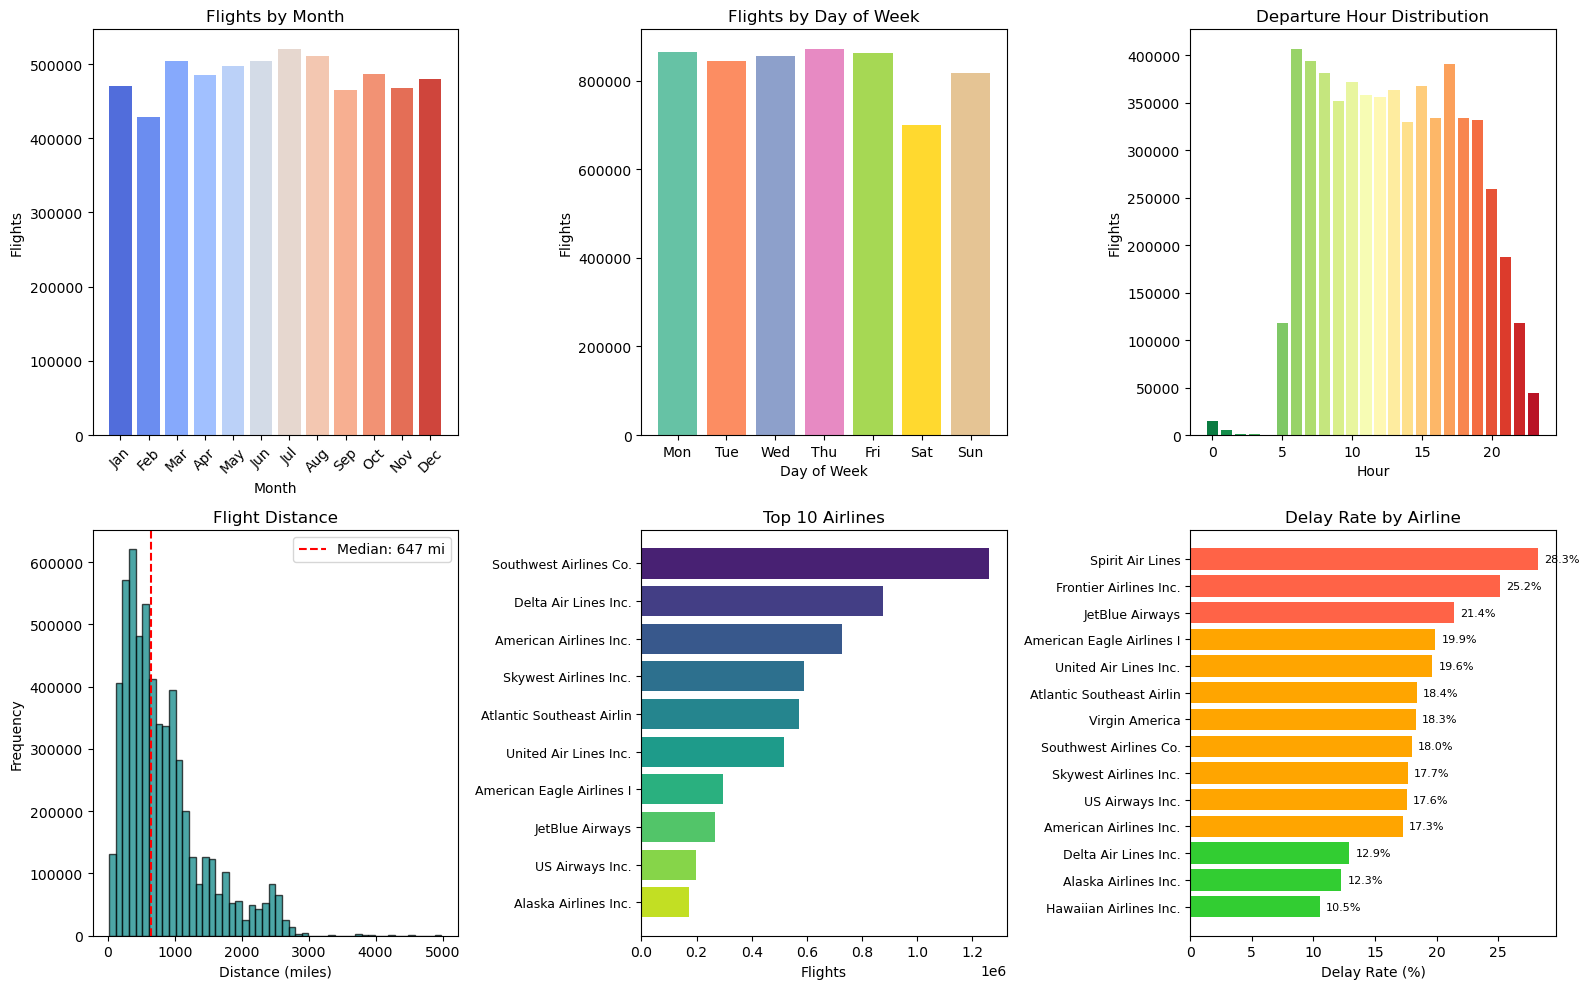

In [3]:
"""
Feature Distributions

Visualize the distribution of key features including temporal patterns,
flight distance, and airline-level statistics.
"""

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Flights by Month
month_counts = df_flights['MONTH'].value_counts().sort_index()
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 0].bar(month_counts.index, month_counts.values,
               color=sns.color_palette("coolwarm", 12))
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Flights')
axes[0, 0].set_title('Flights by Month')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(month_labels, rotation=45)

# Flights by Day of Week
dow_counts = df_flights['DAY_OF_WEEK'].value_counts().sort_index()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(dow_counts.index, dow_counts.values,
               color=sns.color_palette("Set2", 7))
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Flights')
axes[0, 1].set_title('Flights by Day of Week')
axes[0, 1].set_xticks(range(1, 8))
axes[0, 1].set_xticklabels(dow_labels)

# Departure Hour Distribution
dep_hour = df_flights['SCHEDULED_DEPARTURE'] // 100
hour_counts = dep_hour.value_counts().sort_index()
axes[0, 2].bar(hour_counts.index, hour_counts.values,
               color=sns.color_palette("RdYlGn_r", 24))
axes[0, 2].set_xlabel('Hour')
axes[0, 2].set_ylabel('Flights')
axes[0, 2].set_title('Departure Hour Distribution')

# Flight Distance Distribution
axes[1, 0].hist(df_flights['DISTANCE'], bins=50, color='teal',
                edgecolor='black', alpha=0.7)
median_distance = df_flights["DISTANCE"].median()
axes[1, 0].axvline(median_distance, color='red', linestyle='--',
                   label=f'Median: {median_distance:.0f} mi')
axes[1, 0].set_xlabel('Distance (miles)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Flight Distance')
axes[1, 0].legend()

# Top 10 Airlines by Flight Count
airline_counts = df_flights['AIRLINE'].value_counts().head(10)
airline_labels = [airline_names.get(c, c)[:25] for c in airline_counts.index]
axes[1, 1].barh(range(len(airline_labels)), airline_counts.values,
                color=sns.color_palette("viridis", 10))
axes[1, 1].set_yticks(range(len(airline_labels)))
axes[1, 1].set_yticklabels(airline_labels, fontsize=9)
axes[1, 1].set_xlabel('Flights')
axes[1, 1].set_title('Top 10 Airlines')
axes[1, 1].invert_yaxis()

# Delay Rate by Airline
delay_rates = df_flights.groupby('AIRLINE').apply(
    lambda x: (x['ARRIVAL_DELAY'] > 15).mean() * 100
).sort_values(ascending=False)
delay_labels = [airline_names.get(c, c)[:25] for c in delay_rates.index]

# Color code by delay severity: red (>20%), orange (>15%), green (<=15%)
colors = []
for rate in delay_rates.values:
    if rate > 20:
        colors.append('tomato')
    elif rate > 15:
        colors.append('orange')
    else:
        colors.append('limegreen')

axes[1, 2].barh(range(len(delay_labels)), delay_rates.values, color=colors)
axes[1, 2].set_yticks(range(len(delay_labels)))
axes[1, 2].set_yticklabels(delay_labels, fontsize=9)
axes[1, 2].set_xlabel('Delay Rate (%)')
axes[1, 2].set_title('Delay Rate by Airline')
axes[1, 2].invert_yaxis()

for i, rate in enumerate(delay_rates.values):
    axes[1, 2].text(rate + 0.5, i, f'{rate:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.show()

### 2.3 Delay Patterns by Time

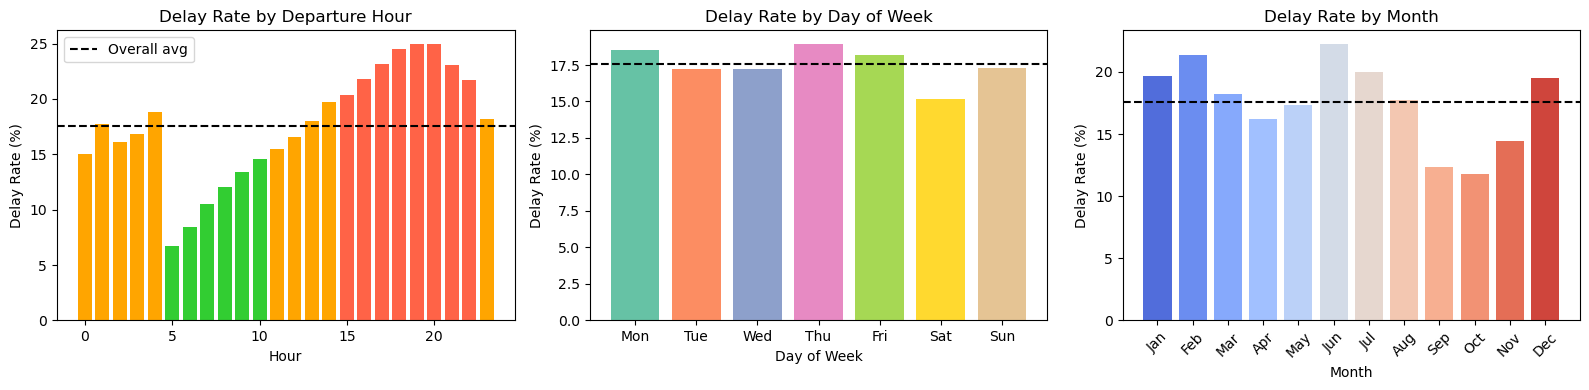

In [4]:
"""
Delay Patterns by Time

Analyze how delay rates vary by departure hour, day of week, and month.
"""

# Create temporary columns for analysis
df_flights['DEP_HOUR'] = df_flights['SCHEDULED_DEPARTURE'] // 100
df_flights['IS_DELAYED'] = (df_flights['ARRIVAL_DELAY'] > 15).astype(int)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Delay rate by hour
hourly_delay = df_flights.groupby('DEP_HOUR')['IS_DELAYED'].mean() * 100

# Color code by delay severity
colors = []
for rate in hourly_delay.values:
    if rate > 20:
        colors.append('tomato')
    elif rate > 15:
        colors.append('orange')
    else:
        colors.append('limegreen')

axes[0].bar(hourly_delay.index, hourly_delay.values, color=colors)
overall_delay_rate = df_flights['IS_DELAYED'].mean() * 100
axes[0].axhline(y=overall_delay_rate, color='black', linestyle='--', label='Overall avg')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Delay Rate (%)')
axes[0].set_title('Delay Rate by Departure Hour')
axes[0].legend()

# Delay rate by day of week
dow_delay = df_flights.groupby('DAY_OF_WEEK')['IS_DELAYED'].mean() * 100
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1].bar(dow_delay.index, dow_delay.values, color=sns.color_palette("Set2", 7))
axes[1].axhline(y=overall_delay_rate, color='black', linestyle='--')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Delay Rate (%)')
axes[1].set_title('Delay Rate by Day of Week')
axes[1].set_xticks(range(1, 8))
axes[1].set_xticklabels(dow_labels)

# Delay rate by month
monthly_delay = df_flights.groupby('MONTH')['IS_DELAYED'].mean() * 100
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[2].bar(monthly_delay.index, monthly_delay.values,
            color=sns.color_palette("coolwarm", 12))
axes[2].axhline(y=overall_delay_rate, color='black', linestyle='--')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Delay Rate (%)')
axes[2].set_title('Delay Rate by Month')
axes[2].set_xticks(range(1, 13))
axes[2].set_xticklabels(month_labels, rotation=45)

plt.tight_layout()
plt.show()

# Clean up temporary columns
df_flights.drop(['DEP_HOUR', 'IS_DELAYED'], axis=1, inplace=True)

## 3. Data Preprocessing

Clean the flight data by:
1. Removing cancelled and diverted flights (not relevant for delay prediction)
2. Handling missing values in key columns
4. Selecting relevant features for modeling
5. Creating binary target variable (DELAYED = 1 if arrival delay > 15 min)

In [2]:
print(f"Original: {len(df_flights):,} rows")

# Remove cancelled and diverted flights
df = df_flights[
    (df_flights['CANCELLED'] == 0) & (df_flights['DIVERTED'] == 0)
].copy()
print(f"After removing cancelled/diverted: {len(df):,} rows")

# Select columns for modeling
cols = [
    'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
    'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE', 'ARRIVAL_DELAY'
]
df = df[cols].copy()

missing_summary = df[cols].isnull().sum()
missing_pct = (missing_summary / len(df) * 100).round(2)

# Missing values in key columns
for col in cols:
    if missing_summary[col] > 0:
        print(f"  {col:25} {missing_summary[col]:>8,} ({missing_pct[col]:>5.2f}%)")

# Remove rows with missing target variable (ARRIVAL_DELAY)
before = len(df)
df = df[df['ARRIVAL_DELAY'].notna()].copy()
removed = before - len(df)
print(f"\n✓ Removed {removed:,} rows with missing ARRIVAL_DELAY")

# Remove rows with missing SCHEDULED_TIME or DISTANCE
before = len(df)
df = df[
    df['SCHEDULED_TIME'].notna() & 
    df['DISTANCE'].notna()
].copy()
removed = before - len(df)
if removed > 0:
    print(f"✓ Removed {removed:,} rows with missing SCHEDULED_TIME/DISTANCE")
else:
    print(f"✓ No missing values in SCHEDULED_TIME/DISTANCE")

# Selecting Relevant features
print("\n--- Selecting Relevant Features ---")

COLS_TO_KEEP = [
    # Temporal features
    'MONTH', 'DAY', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE',
    
    # Route and flight characteristics
    'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
    'DISTANCE', 'SCHEDULED_TIME',
    
    # Target variable
    'ARRIVAL_DELAY'
]

df = df[COLS_TO_KEEP].copy()

# Creating Target Variable
# Delay threshold: 15 minutes (standard industry definition)
DELAY_THRESHOLD = 15

# Create binary target
df['DELAYED'] = (df['ARRIVAL_DELAY'] > DELAY_THRESHOLD).astype(int)

# Analyze target distribution
delayed_count = (df['DELAYED'] == 1).sum()
ontime_count = (df['DELAYED'] == 0).sum()
delay_rate = delayed_count / len(df) * 100

print(f"\nTarget variable: DELAYED (1 if ARRIVAL_DELAY > {DELAY_THRESHOLD} min)")
print(f"  Delayed (1):  {delayed_count:>10,} ({delay_rate:>5.2f}%)")
print(f"  On-time (0):  {ontime_count:>10,} ({100-delay_rate:>5.2f}%)")
print(f"  Class ratio:  {ontime_count/delayed_count:.2f}:1 (on-time:delayed)")

# Drop the continuous ARRIVAL_DELAY column (no longer needed)
df.drop('ARRIVAL_DELAY', axis=1, inplace=True)

print(f"\nFinal dataset: {len(df):,} rows x {df.shape[1]} columns")
print(f"Delay rate: {delay_rate:.2f}%")

Original: 5,819,079 rows
After removing cancelled/diverted: 5,714,008 rows

✓ Removed 0 rows with missing ARRIVAL_DELAY
✓ No missing values in SCHEDULED_TIME/DISTANCE

--- Selecting Relevant Features ---

Target variable: DELAYED (1 if ARRIVAL_DELAY > 15 min)
  Delayed (1):   1,023,498 (17.91%)
  On-time (0):   4,690,510 (82.09%)
  Class ratio:  4.58:1 (on-time:delayed)

Final dataset: 5,714,008 rows x 10 columns
Delay rate: 17.91%


## 4. Train/Validation/Test/Production Split

Split by month to simulate real production scenario:
- Training:   Jan 1 - Sep 30  (Months 1-9,  ~75%)
- Validation: Oct 1 - Oct 31  (Month 10,    ~8%)
- Test:       Nov 1 - Nov 30  (Month 11,    ~8%)
- Production: Dec 1 - Dec 31  (Month 12,    ~9%)

Why temporal split?
1. Prevents data leakage (no future info in training)
2. Matches production reality (predict future from past)
3. Tests generalization to unseen time periods
4. Respects seasonality in flight patterns

In [3]:
import pandas as pd
import numpy as np

print("\n" + "=" * 70)
print("TEMPORAL DATA SPLIT")
print("=" * 70)

# ============================================================================
# Split by Month
# ============================================================================
print("\n--- Splitting Data by Month ---")

train_df = df[df['MONTH'] <= 9].copy()
val_df = df[df['MONTH'] == 10].copy()
test_df = df[df['MONTH'] == 11].copy()
prod_df = df[df['MONTH'] == 12].copy()


total_rows = len(df)

datasets = [
    ('Training', train_df, 'Jan-Sep (1-9)'),
    ('Validation', val_df, 'Oct (10)'),
    ('Test', test_df, 'Nov (11)'),
    ('Production', prod_df, 'Dec (12)')
]

for name, data, month_range in datasets:
    n_rows = len(data)
    pct = n_rows / total_rows * 100
    delay_rate = data['DELAYED'].mean() * 100
    print(f"{name:<12} {n_rows:>10,}  {pct:>6.1f}%    {delay_rate:>6.2f}%      {month_range}")


# ============================================================================
#  Detailed Statistics per Dataset
# ============================================================================
print("\n" + "=" * 70)
print("DETAILED STATISTICS")
print("=" * 70)

for name, data, _ in datasets:
    print(f"\n{name} Dataset:")
    print(f"  Rows: {len(data):,}")
    print(f"  Delayed: {(data['DELAYED'] == 1).sum():,} ({data['DELAYED'].mean()*100:.2f}%)")
    print(f"  Airlines: {data['AIRLINE'].nunique()}")
    print(f"  Airports: {data['ORIGIN_AIRPORT'].nunique()} origin, {data['DESTINATION_AIRPORT'].nunique()} dest")
    print(f"  Avg distance: {data['DISTANCE'].mean():.1f} miles")
    print(f"  Avg scheduled time: {data['SCHEDULED_TIME'].mean():.1f} min")


print("\n" + "=" * 70)
print("TEMPORAL SPLIT COMPLETE")
print("=" * 70)


TEMPORAL DATA SPLIT

--- Splitting Data by Month ---
Training      4,299,046    75.2%     18.73%      Jan-Sep (1-9)
Validation      482,878     8.5%     11.85%      Oct (10)
Test            462,367     8.1%     14.62%      Nov (11)
Production      469,717     8.2%     19.87%      Dec (12)

DETAILED STATISTICS

Training Dataset:
  Rows: 4,299,046
  Delayed: 805,372 (18.73%)
  Airlines: 14
  Airports: 322 origin, 322 dest
  Avg distance: 823.8 miles
  Avg scheduled time: 141.6 min

Validation Dataset:
  Rows: 482,878
  Delayed: 57,237 (11.85%)
  Airlines: 13
  Airports: 306 origin, 307 dest
  Avg distance: 817.2 miles
  Avg scheduled time: 140.7 min

Test Dataset:
  Rows: 462,367
  Delayed: 67,576 (14.62%)
  Airlines: 13
  Airports: 305 origin, 305 dest
  Avg distance: 822.1 miles
  Avg scheduled time: 142.5 min

Production Dataset:
  Rows: 469,717
  Delayed: 93,313 (19.87%)
  Airlines: 13
  Airports: 307 origin, 307 dest
  Avg distance: 840.4 miles
  Avg scheduled time: 145.5 min

TEMP

Our validation set (October) has an unusually low delay rate (11.85%) compared to training (18.73%). This creates a distribution shift that tests our model's ability to generalize across seasonal variations. We prioritize test set (November, 14.62%) and production set (December, 19.87%) performance as more realistic indicators of real-world deployment success.

## 5. Feature Engineering

Engineer 20 features from raw data:
- Temporal: hour, cyclical encoding, peak hours, weekend
- Distance: long-haul indicator, distance buckets
- Target encoding: airline/airport/route delay rates (computed from TRAIN only)
- Volume: airport/route popularity (log-scaled)

CRITICAL: All statistics computed from training data only to prevent leakage.

In [5]:
print("\n" + "=" * 70)
print("FEATURE ENGINEERING")
print("=" * 70)

# ============================================================================
# 1. Temporal Features (Row-Level)
# ============================================================================
print("\n--- Creating Temporal Features ---")


def add_temporal_features(data):
    """Add time-based features"""
    # Extract hour from SCHEDULED_DEPARTURE (HHMM format)
    data['DEP_HOUR'] = data['SCHEDULED_DEPARTURE'] // 100

    # Cyclical encoding (captures 23:00 is close to 01:00)
    data['HOUR_SIN'] = np.sin(2 * np.pi * data['DEP_HOUR'] / 24)
    data['HOUR_COS'] = np.cos(2 * np.pi * data['DEP_HOUR'] / 24)
    
    # Peak hours: morning (6-9) or evening (16-20)
    is_morning = (data['DEP_HOUR'] >= 6) & (data['DEP_HOUR'] <= 9)
    is_evening = (data['DEP_HOUR'] >= 16) & (data['DEP_HOUR'] <= 20)
    data['IS_PEAK_HOUR'] = (is_morning | is_evening).astype(int)
    
    # Weekend indicator
    data['IS_WEEKEND'] = (data['DAY_OF_WEEK'] >= 6).astype(int)
    
    return data

for data in [train_df, val_df, test_df, prod_df]:
    add_temporal_features(data)

print("✓ DEP_HOUR, HOUR_SIN, HOUR_COS, IS_PEAK_HOUR, IS_WEEKEND")

# ============================================================================
# 2. Distance-Based Features (Row-Level)
# ============================================================================
print("\n--- Creating Distance Features ---")

def add_distance_features(data):
    """Add distance-based features"""
    # Long-haul flights (> 1500 miles)
    data['IS_LONG_HAUL'] = (data['DISTANCE'] > 1500).astype(int)
    
    # Distance buckets: Short (<500), Medium (500-1500), Long (>1500)
    data['DISTANCE_BUCKET'] = pd.cut(
        data['DISTANCE'],
        bins=[0, 500, 1500, 5000],
        labels=[0, 1, 2]
    ).astype(int)
    
    return data

for data in [train_df, val_df, test_df, prod_df]:
    add_distance_features(data)

print("✓ IS_LONG_HAUL, DISTANCE_BUCKET")

# ============================================================================
# 3. Target Encoding (Computed from TRAIN only!)
# ============================================================================
print("\n--- Creating Target-Encoded Features ---")

# Global delay rate (fallback for unseen categories)
global_delay_rate = train_df['DELAYED'].mean()

# Compute delay rates from TRAINING data only
airline_delay = train_df.groupby('AIRLINE')['DELAYED'].mean().to_dict()
origin_delay = train_df.groupby('ORIGIN_AIRPORT')['DELAYED'].mean().to_dict()
dest_delay = train_df.groupby('DESTINATION_AIRPORT')['DELAYED'].mean().to_dict()

# Create route ID
for data in [train_df, val_df, test_df, prod_df]:
    data['ROUTE'] = data['ORIGIN_AIRPORT'] + '_' + data['DESTINATION_AIRPORT']

route_delay = train_df.groupby('ROUTE')['DELAYED'].mean().to_dict()

# Apply to all datasets (unseen categories get global rate)
for data in [train_df, val_df, test_df, prod_df]:
    data['AIRLINE_DELAY_RATE'] = data['AIRLINE'].map(airline_delay).fillna(global_delay_rate)
    data['ORIGIN_DELAY_RATE'] = data['ORIGIN_AIRPORT'].map(origin_delay).fillna(global_delay_rate)
    data['DEST_DELAY_RATE'] = data['DESTINATION_AIRPORT'].map(dest_delay).fillna(global_delay_rate)
    data['ROUTE_DELAY_RATE'] = data['ROUTE'].map(route_delay).fillna(global_delay_rate)

print("✓ AIRLINE_DELAY_RATE, ORIGIN_DELAY_RATE, DEST_DELAY_RATE, ROUTE_DELAY_RATE")
print(f"  Global delay rate (fallback): {global_delay_rate:.4f}")

# ============================================================================
# 4. Volume-Based Features (Computed from TRAIN only!)
# ============================================================================
print("\n--- Creating Volume Features ---")

# Compute flight counts from training data
origin_counts = train_df['ORIGIN_AIRPORT'].value_counts().to_dict()
dest_counts = train_df['DESTINATION_AIRPORT'].value_counts().to_dict()
route_counts = train_df['ROUTE'].value_counts().to_dict()

# Apply log-scaled counts (log1p handles zeros gracefully)
for data in [train_df, val_df, test_df, prod_df]:
    data['ORIGIN_FLIGHTS'] = np.log1p(data['ORIGIN_AIRPORT'].map(origin_counts).fillna(0))
    data['DEST_FLIGHTS'] = np.log1p(data['DESTINATION_AIRPORT'].map(dest_counts).fillna(0))
    data['ROUTE_FLIGHTS'] = np.log1p(data['ROUTE'].map(route_counts).fillna(0))

print("✓ ORIGIN_FLIGHTS, DEST_FLIGHTS, ROUTE_FLIGHTS (log-scaled)")

# ============================================================================
# 5. Prepare Final Feature Matrix
# ============================================================================
print("\n--- Preparing Final Features ---")

# Features to use in model
FEATURE_COLS = [
    # Temporal
    'MONTH', 'DAY', 'DAY_OF_WEEK', 'DEP_HOUR', 'SCHEDULED_DEPARTURE',
    'HOUR_SIN', 'HOUR_COS', 'IS_PEAK_HOUR', 'IS_WEEKEND',
    
    # Distance
    'DISTANCE', 'SCHEDULED_TIME', 'IS_LONG_HAUL', 'DISTANCE_BUCKET',
    
    # Target-encoded
    'AIRLINE_DELAY_RATE', 'ORIGIN_DELAY_RATE', 'DEST_DELAY_RATE', 'ROUTE_DELAY_RATE',
    
    # Volume
    'ORIGIN_FLIGHTS', 'DEST_FLIGHTS', 'ROUTE_FLIGHTS'
]

TARGET_COL = 'DELAYED'

# Create feature matrices
X_train = train_df[FEATURE_COLS].copy()
y_train = train_df[TARGET_COL].copy()

X_val = val_df[FEATURE_COLS].copy()
y_val = val_df[TARGET_COL].copy()

X_test = test_df[FEATURE_COLS].copy()
y_test = test_df[TARGET_COL].copy()

X_prod = prod_df[FEATURE_COLS].copy()
y_prod = prod_df[TARGET_COL].copy()

print(f"\n✓ Feature matrix shape: {X_train.shape}")
print(f"✓ Total features: {len(FEATURE_COLS)}")
print(f"✓ Target: {TARGET_COL}")

# ============================================================================
# 6. Summary
# ============================================================================
print("\n" + "=" * 70)
print("FEATURE ENGINEERING COMPLETE")
print("=" * 70)

print(f"\n📊 Dataset Shapes:")
print(f"   X_train: {X_train.shape}  |  y_train: {y_train.shape}")
print(f"   X_val:   {X_val.shape}  |  y_val:   {y_val.shape}")
print(f"   X_test:  {X_test.shape}  |  y_test:  {y_test.shape}")
print(f"   X_prod:  {X_prod.shape}  |  y_prod:  {y_prod.shape}")

print(f"\n📋 Features ({len(FEATURE_COLS)}):")
for i, col in enumerate(FEATURE_COLS, 1):
    print(f"   {i:2d}. {col}")



FEATURE ENGINEERING

--- Creating Temporal Features ---
✓ DEP_HOUR, HOUR_SIN, HOUR_COS, IS_PEAK_HOUR, IS_WEEKEND

--- Creating Distance Features ---
✓ IS_LONG_HAUL, DISTANCE_BUCKET

--- Creating Target-Encoded Features ---
✓ AIRLINE_DELAY_RATE, ORIGIN_DELAY_RATE, DEST_DELAY_RATE, ROUTE_DELAY_RATE
  Global delay rate (fallback): 0.1873

--- Creating Volume Features ---
✓ ORIGIN_FLIGHTS, DEST_FLIGHTS, ROUTE_FLIGHTS (log-scaled)

--- Preparing Final Features ---

✓ Feature matrix shape: (4299046, 20)
✓ Total features: 20
✓ Target: DELAYED

FEATURE ENGINEERING COMPLETE

📊 Dataset Shapes:
   X_train: (4299046, 20)  |  y_train: (4299046,)
   X_val:   (482878, 20)  |  y_val:   (482878,)
   X_test:  (462367, 20)  |  y_test:  (462367,)
   X_prod:  (469717, 20)  |  y_prod:  (469717,)

📋 Features (20):
    1. MONTH
    2. DAY
    3. DAY_OF_WEEK
    4. DEP_HOUR
    5. SCHEDULED_DEPARTURE
    6. HOUR_SIN
    7. HOUR_COS
    8. IS_PEAK_HOUR
    9. IS_WEEKEND
   10. DISTANCE
   11. SCHEDULED_TIME
  

## 6. Feature Store

Create offline and online store in sagemaker

In [ ]:
import sagemaker
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker import get_execution_role
import pandas as pd
import time

print("\n" + "=" * 70)
print("SAGEMAKER FEATURE STORE (ASYNC)")
print("=" * 70)

sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

print(f"\nBucket: {bucket}")

# ============================================================================
# Prepare Features
# ============================================================================
print("\n--- Preparing Features ---")

def prepare_for_feature_store(data):
    df = data.copy()
    
    df['flight_id'] = (
        "2015-" +
        df['MONTH'].astype(str).str.zfill(2) + "-" +
        df['DAY'].astype(str).str.zfill(2) + "-" +
        df['AIRLINE'].astype(str) + "-" +
        df['ORIGIN_AIRPORT'].astype(str) + "-" +
        df['DESTINATION_AIRPORT'].astype(str) + "-" +
        df['SCHEDULED_DEPARTURE'].astype(int).astype(str).str.zfill(4)
    )
    
    df['event_time'] = pd.to_datetime(
        '2015-' + df['MONTH'].astype(str) + '-' + df['DAY'].astype(str)
    ).astype(int) / 10**9
    
    cols = ['flight_id', 'event_time'] + [c for c in df.columns if c not in ['flight_id', 'event_time']]
    return df[cols]

train_fs = prepare_for_feature_store(train_df)
val_fs = prepare_for_feature_store(val_df)
test_fs = prepare_for_feature_store(test_df)
prod_fs = prepare_for_feature_store(prod_df)

all_features = pd.concat([train_fs, val_fs, test_fs, prod_fs], ignore_index=True)

print(f"Total records: {len(all_features):,}")

# Handle duplicates
n_unique = all_features['flight_id'].nunique()
if n_unique < len(all_features):
    print(f"Adding row numbers for uniqueness...")
    all_features['flight_id'] = (
        all_features['flight_id'] + "-" + 
        all_features.groupby('flight_id').cumcount().astype(str)
    )

# ============================================================================
# Create Feature Group
# ============================================================================
print("\n--- Creating Feature Group ---")

feature_group_name = "flight-delay-features"
print(f"Name: {feature_group_name}")

feature_group = FeatureGroup(
    name=feature_group_name,
    sagemaker_session=sagemaker_session
)

feature_group.load_feature_definitions(data_frame=all_features)

s3_uri = f"s3://{bucket}/aai540-group1/feature-store/{feature_group_name}"


feature_group.create(
    s3_uri=s3_uri,
    record_identifier_name='flight_id',
    event_time_feature_name='event_time',
    role_arn=role,
    enable_online_store=False,  # ← Disabled for faster ingestion
    description="Flight delay features"
)

print("Waiting for creation...")
status = feature_group.describe().get("FeatureGroupStatus")
while status == "Creating":
    time.sleep(30)
    status = feature_group.describe().get("FeatureGroupStatus")

print(f"✓ Status: {status}")

# FIX 3: Add longer wait after creation
print("\nWaiting 60 seconds for feature group to stabilize...")
time.sleep(60)

# ============================================================================
# Ingest Features (ASYNC)
# ============================================================================
print("\n--- Ingesting Features (Async) ---")
print(f"Starting ingestion of {len(all_features):,} records...")

# FIX 4: Use smaller batches with max_processes
try:
    feature_group.ingest(
        data_frame=all_features,
        max_workers=3,
        max_processes=1,  # ← Limit processes
        wait=False
    )
    print("✓ Ingestion started successfully")
except Exception as e:
    print(f"⚠️  Ingestion error: {e}")

# ============================================================================
# Summary
# ============================================================================
print("\n" + "=" * 70)
print("FEATURE GROUP CREATED")
print("=" * 70)

print(f"\nFeature Group: {feature_group_name}")
print(f"Records: {len(all_features):,}")
print(f"Online Store: Disabled (faster ingestion)")
print(f"Offline Store: ✓")
print(f"S3: {s3_uri}")

print("\n⏳ Ingestion running in background (15-30 min)")
print("\nTo check progress later:")
print(f"  fg_name = '{feature_group_name}'")
print("  fg = FeatureGroup(name=fg_name, sagemaker_session=sagemaker.Session())")
print("  fg.describe()")


SAGEMAKER FEATURE STORE (ASYNC)

Bucket: sagemaker-us-east-1-425709451100

--- Preparing Features ---


## 6. XGBoost Model Training

Train gradient boosted classifier with:
- Relaxed hyperparameters (let model learn patterns)
- Class weighting for imbalance (4.58:1 ratio)
- Early stopping on validation AUC
- Comprehensive evaluation metrics

In [ ]:
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import time

print("\n" + "=" * 70)
print("XGBOOST BASELINE MODEL")
print("=" * 70)

# ============================================================================
# 1. Calculate Class Weight
# ============================================================================
print("\n--- Class Weight Calculation ---")

# Class imbalance ratio
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive

print(f"Negative class (on-time): {n_negative:,}")
print(f"Positive class (delayed): {n_positive:,}")
print(f"Imbalance ratio: {scale_pos_weight:.2f}:1")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# ============================================================================
# 2. Initialize and Train Model
# ============================================================================
print("\n--- Training XGBoost ---")

# Hyperparameters (relaxed to allow learning)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': scale_pos_weight,
    
    # Tree structure
    'max_depth': 8,              # Allow deeper trees
    'learning_rate': 0.1,        # Moderate learning rate
    'n_estimators': 500,         # Enough trees to converge
    
    # Regularization (light)
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,       # Relaxed
    'gamma': 0,                  # No penalty for splits
    'reg_alpha': 0,              # No L1
    'reg_lambda': 1.0,           # Light L2
    
    # Performance
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 30
}

print("\nHyperparameters:")
for key, value in params.items():
    if key not in ['n_jobs', 'random_state', 'early_stopping_rounds']:
        print(f"  {key:20s} = {value}")

# Initialize model
model = xgb.XGBClassifier(**params)

# Train with early stopping
print("\nTraining (showing every 50 iterations)...")
start_time = time.time()

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=50
)

elapsed = time.time() - start_time

print(f"\n✓ Training complete in {elapsed:.1f}s")
print(f"✓ Best iteration: {model.best_iteration}")
print(f"✓ Best validation AUC: {model.best_score:.4f}")

# ============================================================================
# 3. Predictions
# ============================================================================
print("\n--- Generating Predictions ---")

# Predict probabilities
y_train_prob = model.predict_proba(X_train)[:, 1]
y_val_prob = model.predict_proba(X_val)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]
y_prod_prob = model.predict_proba(X_prod)[:, 1]

# Predict classes (default threshold 0.5)
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)
y_prod_pred = model.predict(X_prod)

print("✓ Predictions generated for all datasets")

# ============================================================================
# 4. Evaluation Metrics
# ============================================================================
print("\n" + "=" * 70)
print("MODEL EVALUATION")
print("=" * 70)

def evaluate(y_true, y_pred, y_prob, dataset_name):
    """Calculate and display metrics"""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    
    print(f"\n{dataset_name}:")
    print(f"  AUC:       {auc:.4f}")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    return {'auc': auc, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1}

# Evaluate all datasets
train_metrics = evaluate(y_train, y_train_pred, y_train_prob, "Training")
val_metrics = evaluate(y_val, y_val_pred, y_val_prob, "Validation")
test_metrics = evaluate(y_test, y_test_pred, y_test_prob, "Test")
prod_metrics = evaluate(y_prod, y_prod_pred, y_prod_prob, "Production")

# ============================================================================
# 5. Confusion Matrix (Test Set)
# ============================================================================
print("\n--- Test Set Confusion Matrix ---")

cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n                Predicted")
print(f"                0        1")
print(f"Actual  0    {tn:>6,}  {fp:>6,}")
print(f"        1    {fn:>6,}  {tp:>6,}")

print(f"\nTrue Negatives:  {tn:,} (correctly predicted on-time)")
print(f"False Positives: {fp:,} (predicted delayed, actually on-time)")
print(f"False Negatives: {fn:,} (predicted on-time, actually delayed)")
print(f"True Positives:  {tp:,} (correctly predicted delayed)")

# ============================================================================
# 6. Summary
# ============================================================================
print("\n" + "=" * 70)
print("BASELINE MODEL SUMMARY")
print("=" * 70)

print(f"\n📊 Performance Comparison:")
print(f"\n{'Dataset':<12} {'AUC':<8} {'F1':<8} {'Precision':<11} {'Recall'}")
print("-" * 55)
for name, metrics in [
    ('Training', train_metrics),
    ('Validation', val_metrics),
    ('Test', test_metrics),
    ('Production', prod_metrics)
]:
    print(f"{name:<12} {metrics['auc']:.4f}   {metrics['f1']:.4f}   "
          f"{metrics['prec']:.4f}      {metrics['rec']:.4f}")

## Feature Importance

In [ ]:
"""
Feature Importance

Analyze which features contribute most to the model's predictions.
"""

# Create importance DataFrame
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Display feature importance
print("Feature Importance:")
print("=" * 50)
for i, (_, row) in enumerate(importance_df.iterrows(), 1):
    print(f"{i:2}. {row['Feature']:25} {row['Importance']:.4f}")

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))

colors = sns.color_palette("viridis", len(importance_df))
ax.barh(range(len(importance_df)), importance_df['Importance'].values, color=colors)
ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels(importance_df['Feature'].values)
ax.set_xlabel('Importance')
ax.set_title('XGBoost Feature Importance')
ax.invert_yaxis()

# Add value labels
for i, imp in enumerate(importance_df['Importance'].values):
    ax.text(imp + 0.002, i, f'{imp:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()